### Lab session: representing a digital surface model with a neural network

In [ ]:
pipeline = """
[
    "LHD_FXX_0808_6485_PTS_C_LAMB93_IGN69.copc.laz",
    {
        "type": "filters.sort",
        "dimension": "Z"
    }
]
"""

import pdal
r = pdal.Pipeline(pipeline)
#r.validate()
r.execute()
arrays = r.arrays


In [3]:
import numpy as np

N = arrays[0].shape[0]
X = np.zeros(N,)
Y = np.zeros(N,)
Z = np.zeros(N,)
I = np.zeros(N,)

for n in range(N):
    pt = arrays[0][n]
    X[n] = pt[0]
    Y[n] = pt[1]
    Z[n] = pt[2]
    I[n] = pt[3]


In [4]:
%matplotlib ipympl
#%matplotlib widget

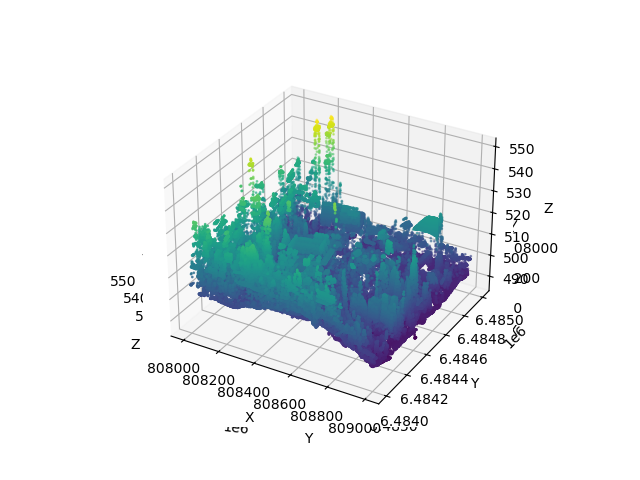

In [8]:
import matplotlib.pyplot as plt

fig = plt.figure(1)
ax = fig.add_subplot(projection='3d')
ax.scatter(X[::100], Y[::100], Z[::100], c=Z[::100], marker='o', s=1)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [6]:
selx = (X>808305)*(X<808538)
sely = (Y>6484516)*(Y<6484626)
sel = selx*sely
I[I>10000] = 10000 #np.max(I[I!=np.max(I)])


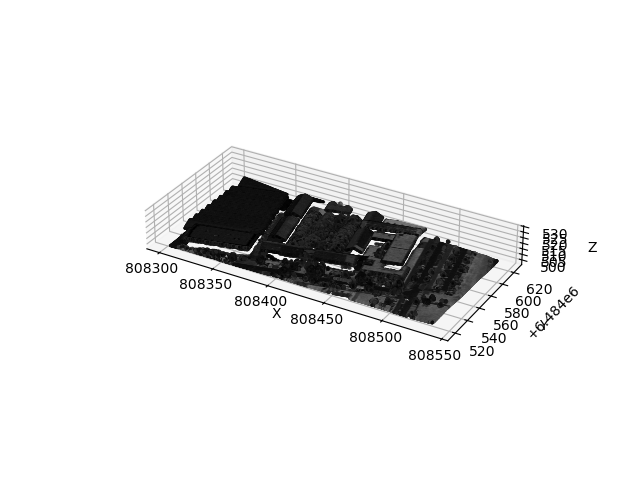

In [7]:
fig = plt.figure(2)
ax = fig.add_subplot(projection='3d')
ax.scatter(X[sel], Y[sel], Z[sel], c=I[sel], marker='o', s=1, cmap='gray')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_aspect('equal')

plt.show()

In [9]:
Xsel = X[sel]
Ysel = Y[sel]
Zsel = Z[sel]
Isel = I[sel]
Nsel = Xsel.shape[0]

Nsmall = 50000
pts = np.rint(np.linspace(Nsel/(2*(Nsmall-1)),Nsel-Nsel/(2*(Nsmall-1)),num=Nsmall)+(np.random.rand(Nsmall)-.5)*Nsel/(Nsmall-1)).astype(np.int32)-1

Xsmall = Xsel[pts]
Ysmall = Ysel[pts]
Zsmall = Zsel[pts]
Ismall = Isel[pts]



In [10]:
Ismall[Ismall==np.max(Ismall)] = np.max(Ismall[Ismall!=np.max(Ismall)])

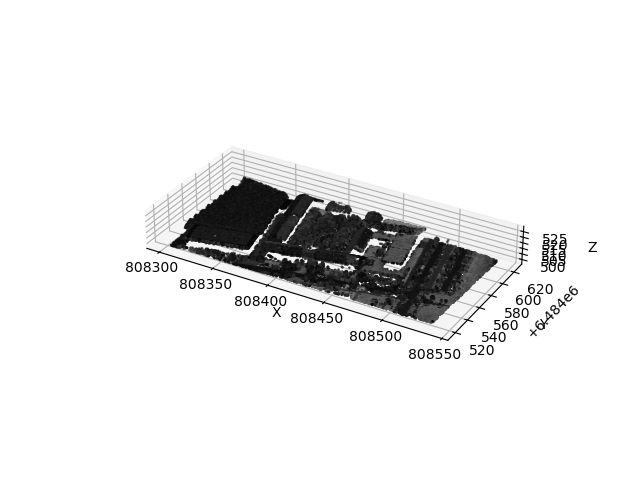

In [11]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
#ax.scatter(Xsmall, Ysmall, Zsmall, c=Ismall.astype(np.float64), marker='o', s=1)
#ax.scatter(Xsmall, Ysmall, Zsmall, c=(Ismall.astype(np.float64)-np.min(Ismall))/(np.max(Ismall)-np.min(Ismall)), marker='o', s=1,cmap='gray')
ax.scatter(Xsmall, Ysmall, Zsmall, c=(Ismall.astype(np.float64))/np.max(Ismall), marker='o', s=1,cmap='gray')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_aspect('equal')

plt.show()